# Evaluation
* Here we compute matrices of BLEU scores, first without any alignment, then with alignment. 
* `Preparation.ipynb` was run before to create the files within `translations`

## Direct Evaluation
* Compute Scores immediately after translation
* Assumption: Alignment was preserved by the translator, so we only need to create triplets.

In [1]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager
parts = {
    'opus': {'dm':Opus100Manager(), 'pairs':Opus100Manager.get_pairs()},
    'ep': {'dm':EuroParlManager(), 'pairs':EuroParlManager.get_pairs()},
    'flores': {'dm':FloresPlusManager(), 'pairs':FloresPlusManager.get_pairs()}
}

translators = ['gpt', 'deepl']

In [2]:
from scripts.post_process import direct_triplet_align, load_sents_from_file
from os.path import join

for dataset, content in parts.items():
    dm = content['dm']
    pairs = content['pairs']
    for pair in pairs:
        s,t = pair
        for translator in translators:
            filename = f'{dataset}-{translator}-{s}-{t}'
            mt_sents = load_sents_from_file(folder='translations', filename=filename)
            src_sents, tgt_sents = dm.get_sentence_pairs(s, t, num_of_sents=400)
            direct_triplet_align(
                mt_sents=mt_sents,
                src_sents=src_sents,
                ref_sents=tgt_sents,
                folder_path='direct_triplets',
                filename=filename
            )

In [3]:
from scripts.scoring import ResultProducer
import os
from os.path import join

files = os.listdir('direct_triplets')
os.makedirs('direct_results', exist_ok=True)

result_setup = ['ep-gpt', 'ep-deepl', 'flores-gpt', 'flores-deepl', 'opus-gpt', 'opus-deepl']

for rs in result_setup:
    l2f = {f.replace(f'{rs}-', '').replace('.jsonl', ''):join('direct_triplets', f) for f in files if f.startswith(rs)}
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('direct_results', f'{rs}.csv'))

In [4]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv
res_files = os.listdir('direct_results')
res2df = {f.replace('.csv', ''):{'file':join('direct_results', f)} for f in res_files}

for rs, content in res2df.items():
    file_path = content['file']
    res2df[rs]['BLEU'] = create_matrix_from_csv(file_path, metric='BLEU')

ep-deepl


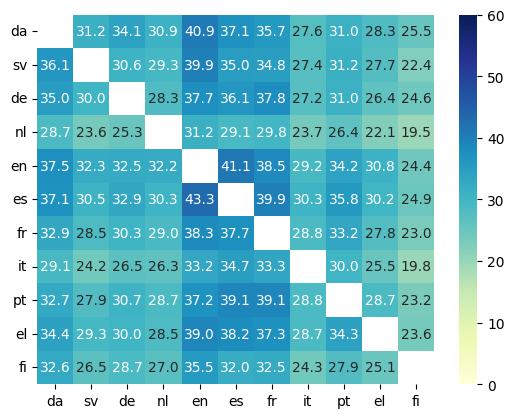


ep-gpt


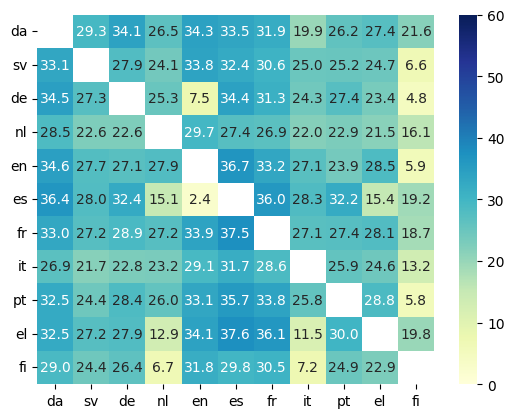


flores-deepl


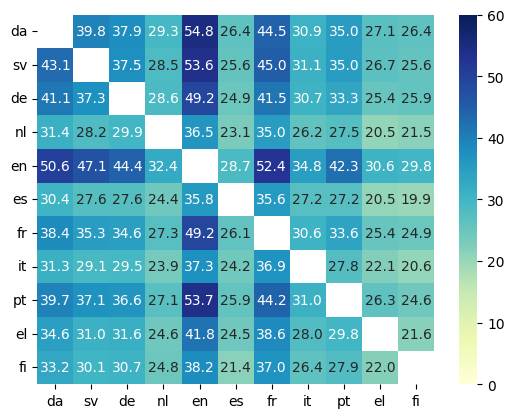


flores-gpt


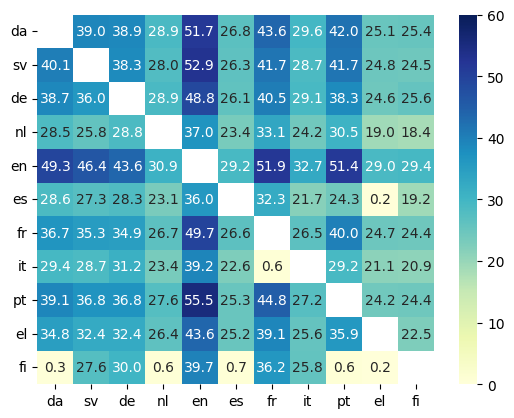


opus-deepl


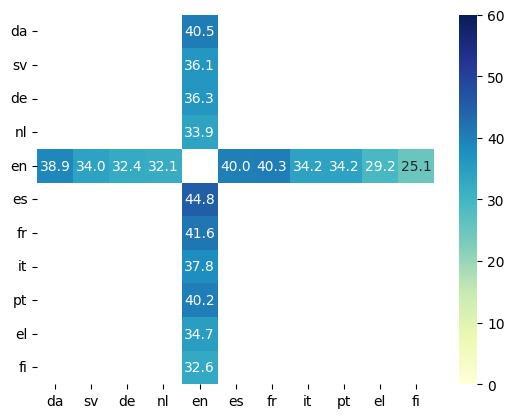


opus-gpt


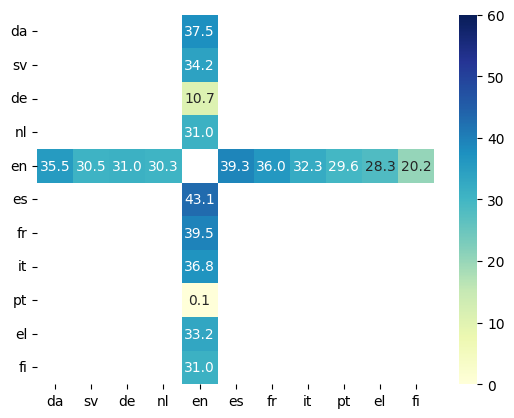

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
for key in res2df:
    out = res2df[key]['BLEU'].round(1)
    out = out.reindex(index=order, columns=order)
    print(key)
    sns.heatmap(out, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, vmin=0, vmax=60)
    plt.yticks(rotation=0)
    plt.show()
    print()

* Now we can check if the pairs we assumed to be misaligned have very low BLEU scores


In [6]:
from os.path import join
import json
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

mismatches = {
    'ep-gpt':[],
    'flores-gpt':[],
    'opus-gpt':[],
}

for prefix, info in prefix2file.items():
    dataset, translator, s, t = prefix.split('-')
    key = f'{dataset}-{translator}'
    outlines = info['log']['out_lines']
    if outlines!=400:
        score = res2df[key]['BLEU'].loc[s, t]
        mismatches[key].append((f'{s}-{t}', score))

for key in mismatches:
    print(key)
    for item in sorted(mismatches[key], key=lambda x: x[1], reverse=True):
        label, score = item
        print(f'{label}: {score:.2f}')
    print()

ep-gpt
da-it: 19.91
es-el: 15.40
es-nl: 15.05
it-fi: 13.18
el-nl: 12.86
el-it: 11.54
de-en: 7.48
fi-it: 7.24
fi-nl: 6.73
sv-fi: 6.63
en-fi: 5.88
pt-fi: 5.85
de-fi: 4.77
es-en: 2.41

flores-gpt
fi-es: 0.65
it-fr: 0.62
fi-nl: 0.60
fi-pt: 0.58
fi-da: 0.29
es-el: 0.23
fi-el: 0.22

opus-gpt
de-en: 10.65
pt-en: 0.11



## Post-Processed Evaluation
* Alignment was conducted on Google Collab using `bertalign`
* The notebook can be found [here](https://colab.research.google.com/drive/1xlwQPctsOGjZB2NpB9WNtzWPae_Oj4gt?usp=sharing)

In [7]:

from scripts.post_process import post_triplet_align, load_aligned_sents_from_file
import os
from os.path import join
src2hyp_fo = 'source2translations'
src2ref_fo = 'source2reference'

filenames = [f.replace('.jsonl', '') for f in os.listdir(src2hyp_fo)]


In [8]:
fn2align_cnt = {}
types = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']
type2align_cnts = {t: [] for t in types}

for fn in filenames:
    dataset, translator, s, t = fn.split('-')
    src_sents_a, mt_sents_a = load_aligned_sents_from_file(fn, folder=src2hyp_fo)
    key = f'{dataset}-{s}-{t}'
    src_sents_o, ref_sents_o = load_aligned_sents_from_file(key, folder=src2ref_fo)
    align_cnt = post_triplet_align(
        src_sents_org=src_sents_o,
        src_sents_ali=src_sents_a,
        ref_sents_org=ref_sents_o,
        mt_sents_ali=mt_sents_a,
        folder_path='post_triplets',
        filename=fn)
    
    fn2align_cnt[fn] = align_cnt
    type2align_cnts[f'{dataset}-{translator}'].append(align_cnt)


for t, ac in type2align_cnts.items():
    max_cnt = max(ac)
    min_cnt = min(ac)
    mean = sum(ac) / len(ac)
    print(t)
    print(f'min: {min_cnt:.2f}')
    print(f'max: {max_cnt:.2f}')
    print(f'mean: {mean:.2f}')

ep-gpt
min: 329.00
max: 396.00
mean: 374.74
ep-deepl
min: 328.00
max: 395.00
mean: 377.38
flores-gpt
min: 390.00
max: 428.00
mean: 417.58
flores-deepl
min: 390.00
max: 428.00
mean: 417.23
opus-gpt
min: 361.00
max: 399.00
mean: 382.95
opus-deepl
min: 361.00
max: 398.00
mean: 383.85


In [9]:
import json
with open('post_triplet_align_cnt.json', 'w') as f:
    json.dump(fn2align_cnt, fp=f, indent=4)

In [10]:
from scripts.scoring import ResultProducer
import os
from os.path import join

files = os.listdir('post_triplets')
os.makedirs('post_results', exist_ok=True)

result_setup = ['ep-gpt', 'ep-deepl', 'flores-gpt',
                'flores-deepl', 'opus-gpt', 'opus-deepl']

for rs in result_setup:
    l2f = {f.replace(f'{rs}-', '').replace('.jsonl', '')
                     : join('post_triplets', f) for f in files if f.startswith(rs)}
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('post_results', f'{rs}.csv'))

In [11]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv
res_files = os.listdir('post_results')
post_res2df = {f.replace('.csv', ''): {'file': join(
    'post_results', f)} for f in res_files}

for rs, content in post_res2df.items():
    file_path = content['file']
    post_res2df[rs]['BLEU'] = create_matrix_from_csv(file_path, metric='BLEU')
    post_res2df[rs]['CHRF'] = create_matrix_from_csv(file_path, metric='chrF')


ep-deepl


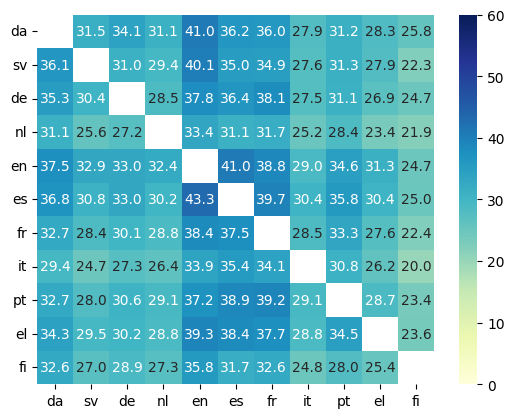


ep-gpt


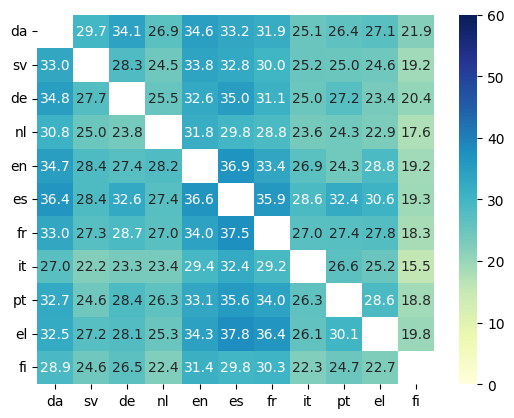


flores-deepl


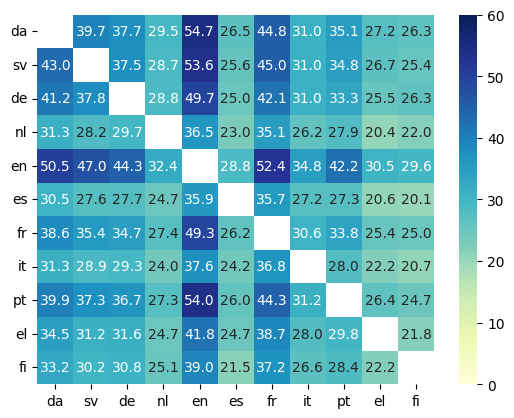


flores-gpt


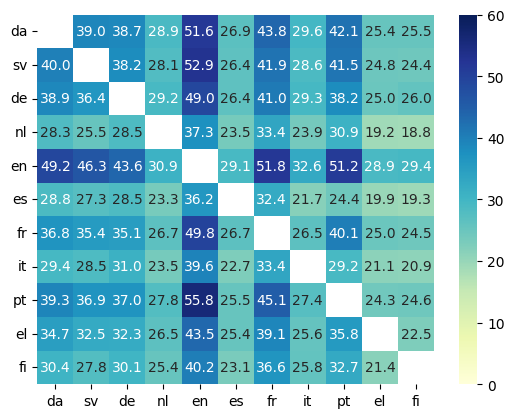


opus-deepl


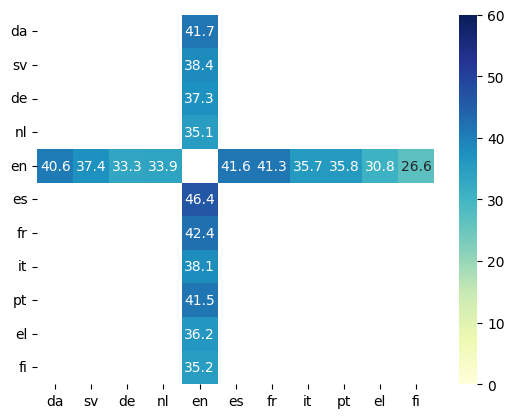


opus-gpt


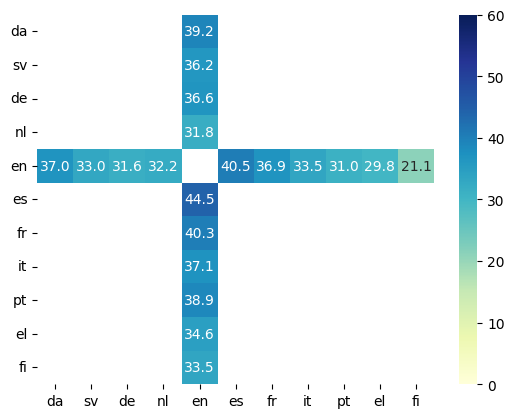

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
for key in post_res2df:
    out = post_res2df[key]['BLEU'].round(1)
    out = out.reindex(index=order, columns=order)
    print(key)
    sns.heatmap(out, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, vmin=0, vmax=60)
    plt.yticks(rotation=0)
    plt.show()
    print()

In [13]:
import numpy as np
for key in post_res2df:
    out = post_res2df[key]['BLEU'] - res2df[key]['BLEU']
    print(key)
    print('mean', f'{np.nanmean(out.values):.2f}')
    print('max', f'{np.nanmax(out.values):.2f}')
    print('min', f'{np.nanmin(out.values):.2f}')
    print()

ep-deepl
mean 0.32
max 2.43
min -0.91

ep-gpt
mean 2.15
max 34.19
min -0.56

flores-deepl
mean 0.09
max 0.74
min -0.23

flores-gpt
mean 1.74
max 32.75
min -0.29

opus-deepl
mean 1.52
max 3.40
min 0.23

opus-gpt
mean 4.45
max 38.80
min 0.23



* We can check if the misaligned were improved with the alignment

In [16]:
from os.path import join
import json
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

mismatches = {
    'ep-gpt': [],
    'flores-gpt': [],
    'opus-gpt': [],
}

for prefix, info in prefix2file.items():
    dataset, translator, s, t = prefix.split('-')
    key = f'{dataset}-{translator}'
    outlines = info['log']['out_lines']
    if outlines != 400:
        score = res2df[key]['BLEU'].loc[s, t]
        improved = post_res2df[key]['BLEU'].loc[s, t]
        mismatches[key].append((f'{s}-{t}', score, improved))

for key in mismatches:
    print(key)
    for item in sorted(mismatches[key], key=lambda x: x[1], reverse=True):
        label, score, improved = item
        print(f'{label}: {score:.2f} -> {improved:.2f}')
    print()

ep-gpt
da-it: 19.91 -> 25.13
es-el: 15.40 -> 30.55
es-nl: 15.05 -> 27.40
it-fi: 13.18 -> 15.49
el-nl: 12.86 -> 25.28
el-it: 11.54 -> 26.05
de-en: 7.48 -> 32.61
fi-it: 7.24 -> 22.30
fi-nl: 6.73 -> 22.44
sv-fi: 6.63 -> 19.18
en-fi: 5.88 -> 19.21
pt-fi: 5.85 -> 18.76
de-fi: 4.77 -> 20.43
es-en: 2.41 -> 36.59

flores-gpt
fi-es: 0.65 -> 23.09
it-fr: 0.62 -> 33.37
fi-nl: 0.60 -> 25.39
fi-pt: 0.58 -> 32.68
fi-da: 0.29 -> 30.45
es-el: 0.23 -> 19.87
fi-el: 0.22 -> 21.36

opus-gpt
de-en: 10.65 -> 36.60
pt-en: 0.11 -> 38.91



## Post-Processed Evaluation (V2)
* Alignments doen on pre-split; so no sentence splitting by `bertalign`
* Take advantage of existing alignments as much as possible.

In [17]:
from scripts.post_process import post_triplet_align, load_aligned_sents_from_file
import os
from os.path import join
src2hyp_split_fo = 'source2translations_split'
filenames = [f.replace('.jsonl', '') for f in os.listdir(src2hyp_split_fo)]

In [18]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager

dms = {
    'ep' : EuroParlManager(),
    'flores' : FloresPlusManager(),
    'opus' : Opus100Manager()
}

fn2align_cnt = {}
types = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']
type2align_cnts = {t: [] for t in types}

for fn in filenames:
    dataset, translator, s, t = fn.split('-')
    src_sents_a, mt_sents_a = load_aligned_sents_from_file(
        fn, folder=src2hyp_split_fo)
    dm = dms[dataset]
    src_sents_o, ref_sents_o = dm.get_sentence_pairs(s, t, num_of_sents=400)
    align_cnt = post_triplet_align(
        src_sents_org=src_sents_o,
        src_sents_ali=src_sents_a,
        ref_sents_org=ref_sents_o,
        mt_sents_ali=mt_sents_a,
        folder_path='post_triplets_split',
        filename=fn)

    fn2align_cnt[fn] = align_cnt
    type2align_cnts[f'{dataset}-{translator}'].append(align_cnt)


for t, ac in type2align_cnts.items():
    max_cnt = max(ac)
    min_cnt = min(ac)
    mean = sum(ac) / len(ac)
    print(t)
    print(f'min: {min_cnt:.2f}')
    print(f'max: {max_cnt:.2f}')
    print(f'mean: {mean:.2f}')

ep-gpt
min: 383.00
max: 398.00
mean: 396.31
ep-deepl
min: 369.00
max: 398.00
mean: 395.77
flores-gpt
min: 310.00
max: 400.00
mean: 390.92
flores-deepl
min: 312.00
max: 400.00
mean: 390.88
opus-gpt
min: 372.00
max: 400.00
mean: 396.60
opus-deepl
min: 386.00
max: 400.00
mean: 397.45


In [19]:
import json
with open('post_triplet_split_align_cnt.json', 'w') as f:
    json.dump(fn2align_cnt, fp=f, indent=4)

In [20]:
from scripts.scoring import ResultProducer
import os
from os.path import join

files = os.listdir('post_triplets_split')
os.makedirs('post_results_split', exist_ok=True)

result_setup = ['ep-gpt', 'ep-deepl', 'flores-gpt',
                'flores-deepl', 'opus-gpt', 'opus-deepl']

for rs in result_setup:
    l2f = {f.replace(f'{rs}-', '').replace('.jsonl', ''): join('post_triplets_split', f) 
           for f in files if f.startswith(rs)}
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('post_results_split', f'{rs}.csv'))

In [21]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv
res_files = os.listdir('post_results_split')
post_split2df = {f.replace('.csv', ''): {'file': join(
    'post_results_split', f)} for f in res_files}

for rs, content in post_split2df.items():
    file_path = content['file']
    post_split2df[rs]['BLEU'] = create_matrix_from_csv(file_path, metric='BLEU')
    post_split2df[rs]['CHRF'] = create_matrix_from_csv(file_path, metric='chrF')


ep-deepl


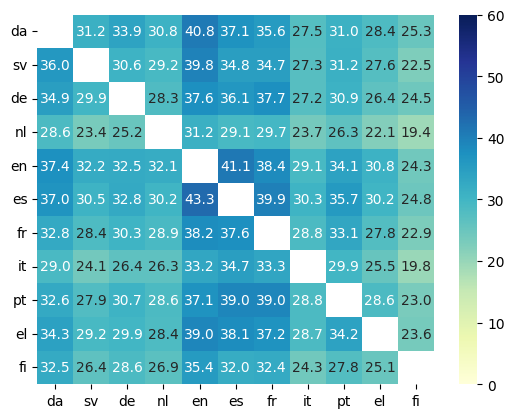


ep-gpt


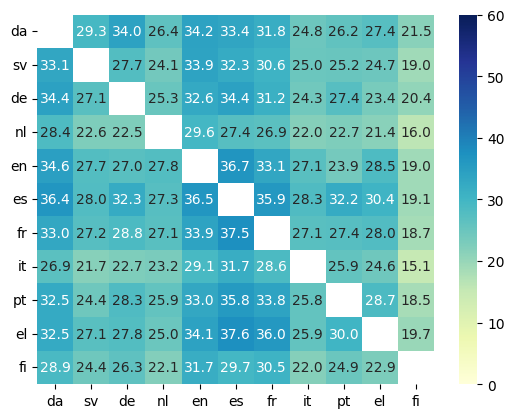


flores-deepl


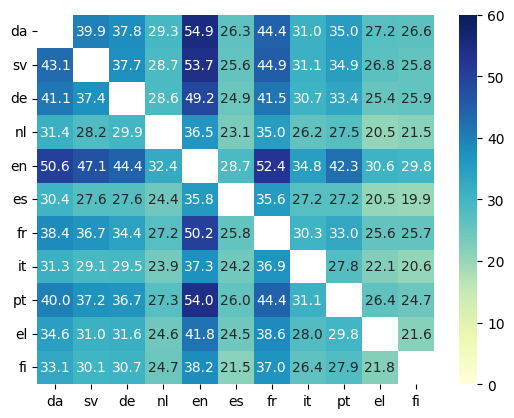


flores-gpt


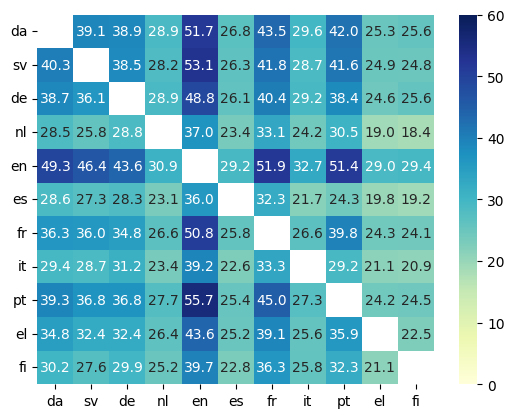


opus-deepl


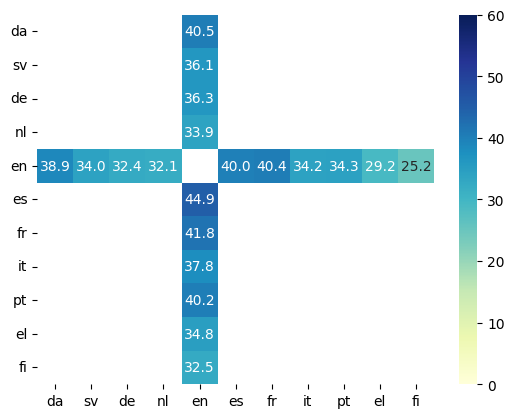


opus-gpt


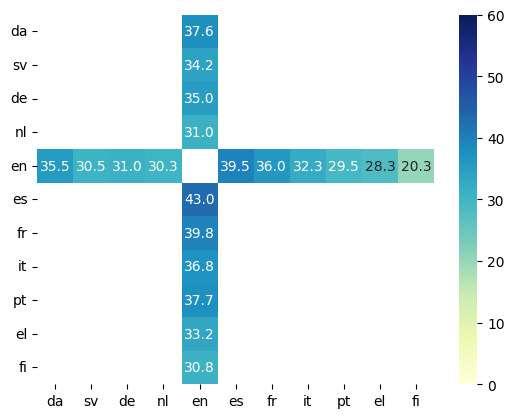

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
for key in post_split2df:
    out = post_split2df[key]['BLEU'].round(1)
    out = out.reindex(index=order, columns=order)
    print(key)
    sns.heatmap(out, annot=True, fmt=".1f",
                cmap="YlGnBu", cbar=True, vmin=0, vmax=60)
    plt.yticks(rotation=0)
    plt.show()
    print()

In [23]:
import numpy as np
for key in post_split2df:
    out = post_split2df[key]['BLEU'] - post_res2df[key]['BLEU']
    print(key)
    print('mean', f'{np.nanmean(out.values):.2f}')
    print('max', f'{np.nanmax(out.values):.2f}')
    print('min', f'{np.nanmin(out.values):.2f}')
    print()

ep-deepl
mean -0.38
max 0.88
min -2.51

ep-gpt
mean -0.33
max 0.52
min -2.41

flores-deepl
mean -0.05
max 1.35
min -0.74

flores-gpt
mean -0.07
max 1.06
min -0.94

opus-deepl
mean -1.48
max -0.23
min -3.40

opus-gpt
mean -1.34
max -0.23
min -2.62



In [24]:
import numpy as np
for key in post_split2df:
    out = post_split2df[key]['CHRF'] - post_res2df[key]['CHRF']
    print(key)
    print('mean', f'{np.nanmean(out.values):.2f}')
    print('max', f'{np.nanmax(out.values):.2f}')
    print('min', f'{np.nanmin(out.values):.2f}')
    print()

ep-deepl
mean -0.27
max 0.51
min -1.65

ep-gpt
mean -0.20
max 0.71
min -1.63

flores-deepl
mean 0.09
max 0.69
min -0.42

flores-gpt
mean 0.07
max 0.65
min -0.41

opus-deepl
mean -1.09
max 0.32
min -2.37

opus-gpt
mean -1.09
max -0.05
min -2.45



* Aligning with/without sentence splitting DOES make a difference.
* From the looks of it, quality goes down if we align without sentence splitting and use sentences as is.


## Alignment Analysis
* We analyse the differences in terms of sentence counts to get a better idea of what exactly is happening there.

In [25]:
import json
with open('post_triplet_align_cnt.json') as f:
    align_sent_cnt_post = json.load(f)

with open('post_triplet_split_align_cnt.json') as f:
    align_sent_cnt_post_split = json.load(f)

In [26]:
for k in sorted(align_sent_cnt_post.items(), key=lambda x : x[1]):
    print(k)

('ep-deepl-nl-it', 328)
('ep-gpt-nl-it', 329)
('ep-deepl-nl-sv', 333)
('ep-gpt-nl-sv', 333)
('ep-gpt-sv-it', 334)
('ep-gpt-nl-pt', 335)
('ep-deepl-nl-pt', 336)
('ep-deepl-nl-es', 338)
('ep-gpt-nl-es', 338)
('ep-gpt-nl-fr', 338)
('ep-deepl-nl-el', 339)
('ep-deepl-nl-en', 339)
('ep-deepl-nl-fr', 339)
('ep-gpt-nl-el', 339)
('ep-gpt-nl-en', 339)
('ep-deepl-nl-de', 342)
('ep-gpt-nl-de', 342)
('ep-deepl-nl-da', 343)
('ep-gpt-nl-da', 343)
('ep-gpt-nl-fi', 344)
('ep-gpt-sv-el', 344)
('ep-deepl-nl-fi', 345)
('ep-gpt-de-it', 347)
('ep-gpt-sv-en', 348)
('ep-gpt-sv-pt', 348)
('ep-gpt-sv-nl', 349)
('ep-gpt-sv-da', 351)
('ep-gpt-sv-fr', 351)
('ep-gpt-sv-fi', 356)
('ep-gpt-de-el', 357)
('ep-gpt-de-pt', 360)
('ep-gpt-sv-de', 360)
('ep-deepl-de-it', 361)
('ep-gpt-sv-es', 361)
('opus-deepl-en-fi', 361)
('opus-gpt-en-fi', 361)
('ep-deepl-sv-de', 362)
('opus-deepl-en-sv', 362)
('ep-deepl-da-it', 363)
('ep-gpt-da-it', 364)
('opus-gpt-en-sv', 364)
('ep-gpt-de-es', 365)
('ep-deepl-de-el', 366)
('ep-deepl-en-

In [27]:
for k in sorted(align_sent_cnt_post_split.items(), key=lambda x: x[1]):
    print(k)

('flores-gpt-fr-fi', 310)
('flores-deepl-fr-da', 312)
('flores-deepl-fr-de', 312)
('flores-deepl-fr-el', 312)
('flores-deepl-fr-en', 312)
('flores-deepl-fr-es', 312)
('flores-deepl-fr-fi', 312)
('flores-deepl-fr-it', 312)
('flores-deepl-fr-nl', 312)
('flores-deepl-fr-pt', 312)
('flores-deepl-fr-sv', 312)
('flores-gpt-fr-da', 312)
('flores-gpt-fr-de', 312)
('flores-gpt-fr-el', 312)
('flores-gpt-fr-en', 312)
('flores-gpt-fr-es', 312)
('flores-gpt-fr-it', 312)
('flores-gpt-fr-nl', 312)
('flores-gpt-fr-pt', 312)
('flores-gpt-fr-sv', 312)
('ep-deepl-sv-de', 369)
('opus-gpt-de-en', 372)
('ep-deepl-de-sv', 383)
('ep-gpt-sv-de', 383)
('ep-gpt-de-sv', 384)
('opus-deepl-fr-en', 386)
('opus-gpt-fr-en', 386)
('ep-deepl-sv-nl', 391)
('ep-deepl-fi-sv', 392)
('ep-deepl-sv-el', 392)
('ep-deepl-es-sv', 393)
('ep-deepl-fr-sv', 393)
('ep-deepl-pt-sv', 393)
('ep-deepl-sv-es', 393)
('ep-deepl-sv-fi', 393)
('ep-deepl-sv-fr', 393)
('ep-deepl-sv-it', 393)
('ep-gpt-fi-sv', 393)
('ep-deepl-de-nl', 394)
('ep-dee

In [28]:
from scripts.data_management import FloresPlusManager
from scripts.util import split_sents

dm = FloresPlusManager()
src_sents, tgt_sents = dm.get_sentence_pairs('fr', 'de', num_of_sents=400)

src_text = '\n'.join(src_sents)
src_sents_split = split_sents(src_text, lang='fr')

tgt_text = '\n'.join(src_sents)
tgt_sents_split = split_sents(tgt_text, lang='de')
len(src_sents), len(src_sents_split), len(tgt_sents_split)

(400, 431, 431)

In [29]:
test = []
test2 = []
for s in src_sents:
    s_split = split_sents(s, lang='fr')
    test.append(s_split)
    test2.extend(s_split)

len(test), len(test2)

(400, 431)

In [30]:
snt_cnts = set([len(item) for item in test if len(item)>1])
snt_cnts

{2}

* So we can more or less say that sentence splitting increases the number of sentences because the original datasets have one-to-many alignments, in this case, 1-2 alignments. So 400 French sentences, correspond to actually 431 French sentences.
* If we run `bertalign` with sentence splitting, it'll align 431 French sentences to 431 German sentences; in case of using this specific data.

In [31]:
from scripts.post_process import load_sents_from_file
mt_sents = load_sents_from_file('flores-deepl-fr-de', folder='translations')

mt_sents_split = split_sents('\n'.join(mt_sents), lang='de')
len(mt_sents), len(mt_sents_split)

(400, 431)

* Or in this case, it would also align 431 split French sentences onto 431 split German translations.
* If we do not split, it'll align 400 French sentences to 400 German sentences.

In [32]:
align_sent_cnt_post['flores-deepl-fr-de'], align_sent_cnt_post_split['flores-deepl-fr-de']

(425, 312)

* This difference is rather large, if we use sentence splitting and then align, we gain much more sentences than trying to align without sentence splitting.
* In percentages, 431 -> 425: 1.4% loss, 400 -> 312: 22% loss

### Loss

In [33]:
from os.path import join
import json
with open(join('translations', 'info.json')) as f:
    info = json.load(f)

key2loss_1 = {}

total = 0
for key in align_sent_cnt_post_split:
    log = info[key]['log']
    mt_line_cnt = log['out_lines']
    exp_align_cnt = min(mt_line_cnt, 400)
    diff = exp_align_cnt - align_sent_cnt_post_split[key]
    loss = diff / exp_align_cnt
    key2loss_1[key] = loss 
    total += loss

print(f'Mean loss was: {total/len(align_sent_cnt_post_split):.2f}%')
print(f'Max loss {max(key2loss_1.items(), key=lambda x:x[1])}')

Mean loss was: 0.02%
Max loss ('flores-gpt-fr-fi', 0.225)


In [34]:
key2loss_2 = {}

total = 0
for key in align_sent_cnt_post:
    log = info[key]['log']
    mt_sent_cnt = log['out_sents']
    src_sent_cnt = log['in_sents']
    exp_align_cnt = min(src_sent_cnt, mt_sent_cnt)
    diff = exp_align_cnt - align_sent_cnt_post[key]
    loss = diff / exp_align_cnt
    key2loss_2[key] = loss
    total += loss

print(f'Mean loss was: {total/len(align_sent_cnt_post):.2f}%')
print(f'Max loss {max(key2loss_2.items(), key=lambda x: x[1])}')

Mean loss was: 0.08%
Max loss ('ep-deepl-nl-it', 0.296137339055794)


In [35]:
align_sent_cnt_post['ep-deepl-nl-it']

328